## MNIST Handwritten Digits Classification Experiment

This demo shows how you can use SageMaker Experiment Management Python SDK to organize, track, compare, and evaluate your machine learning (ML) model training experiments.

You can track artifacts for experiments, including data sets, algorithms, hyper-parameters, and metrics. Experiments executed on SageMaker such as SageMaker Autopilot jobs and training jobs will be automatically tracked. You can also track artifacts for additional steps within an ML workflow that come before/after model training e.g. data pre-processing or post-training model evaluation.

The APIs also let you search and browse your current and past experiments, compare experiments, and identify best performing models.

Now we will demonstrate these capabilities through an MNIST handwritten digits classification example. The experiment will be organized as follow:

1. Download and prepare the MNIST dataset.
2. Train a Convolutional Neural Network (CNN) Model. Tune the hyper parameter that configures the number of hidden channels in the model. Track the parameter configurations and resulting model accuracy using SageMaker Experiments Python SDK.
3. Finally use the search and analytics capabilities of Python SDK to search, compare and evaluate the performance of all model versions generated from model tuning in Step 2.
4. We will also see an example of tracing the complete linage of a model version i.e. the collection of all the data pre-processing and training configurations and inputs that went into creating that model version.

Make sure you selected `Python 3 (Data Science)` kernel.

### Install Python SDKs

In [1]:
import sys

In [2]:
!{sys.executable} -m pip install sagemaker-experiments==0.1.24

  Using cached sagemaker_experiments-0.1.24-py3-none-any.whl (36 kB)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


### Install PyTroch

In [3]:
# pytorch version needs to be the same in both the notebook instance and the training job container 
# https://github.com/pytorch/pytorch/issues/25214
!{sys.executable} -m pip install torch==1.1.0
!{sys.executable} -m pip install torchvision==0.3.0
!{sys.executable} -m pip install pillow==6.2.2
!{sys.executable} -m pip install --upgrade sagemaker

     |████████████████████████████████| 676.9 MB 1.6 kB/s  eta 0:00:01    |████▎                           | 90.4 MB 71.4 MB/s eta 0:00:09
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 2.6 MB 8.8 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 2.1 MB 11.7 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.2.0
    Uninstalling Pillow-7.2.0:
      Successfully uninstalled Pillow-7.2.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 396 kB 12.8 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.23.5-py2.py3-none-any.whl size=559644 sha256=d09b0bd43a6722425a23ee19d

### Setup

In [4]:
import time

import boto3
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

set_matplotlib_formats('retina')

In [5]:
sess = boto3.Session()
sm = sess.client('sagemaker')
role = get_execution_role()

### Create a S3 bucket to hold data

In [6]:
# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client('sts').get_caller_identity()["Account"]
bucket = 'sagemaker-experiments-{}-{}'.format(sess.region_name, account_id)
prefix = 'mnist'

try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=bucket)
    else:
        sess.client('s3').create_bucket(Bucket=bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print(e)

### Dataset
We download the MNIST hand written digits dataset, and then apply transformation on each of the image.

In [7]:
# download the dataset
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
train_set = datasets.MNIST('mnist', train=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]), 
    download=True)
                           
test_set = datasets.MNIST('mnist', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]),
    download=False)

  0%|          | 16384/9912422 [00:00<01:17, 127214.94it/s]

9920512it [00:00, 37571564.16it/s]                           


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 579451.55it/s]
  1%|          | 16384/1648877 [00:00<00:10, 151243.89it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 10735325.65it/s]                         
8192it [00:00, 198884.81it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


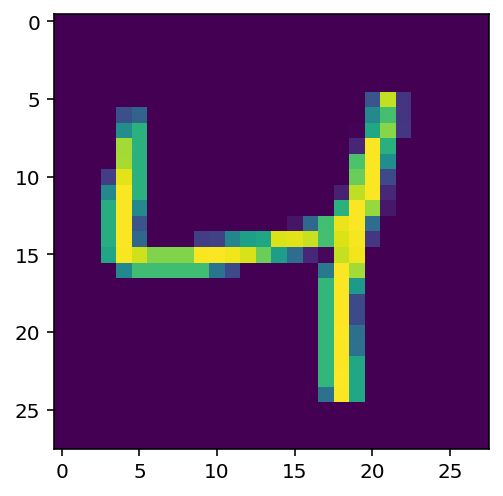

In [8]:
plt.imshow(train_set.data[2].numpy())

After transforming the images in the dataset, we upload it to s3.

In [9]:
inputs = sagemaker.Session().upload_data(path='mnist', bucket=bucket, key_prefix=prefix)
print('input spec: {}'.format(inputs))

input spec: s3://sagemaker-experiments-us-east-1-785827323309/mnist


Now lets track the parameters from the data pre-processing step.

In [10]:
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({
        "normalization_mean": 0.1307,
        "normalization_std": 0.3081,
    })
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="mnist-dataset", media_type="s3/uri", value=inputs)

### Step 1 - Set up the Experiment

Create an experiment to track all the model training iterations. Experiments are a great way to organize your data science work. You can create experiments to organize all your model development work for : [1] a business use case you are addressing (e.g. create experiment named “customer churn prediction”), or [2] a data science team that owns the experiment (e.g. create experiment named “marketing analytics experiment”), or [3] a specific data science and ML project. Think of it as a “folder” for organizing your “files”.

### Create an Experiment

In [11]:
mnist_experiment = Experiment.create(
    experiment_name=f"mnist-hand-written-digits-classification-{int(time.time())}", 
    description="Classification of mnist hand-written digits", 
    sagemaker_boto_client=sm)
print(mnist_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f17fa616198>,experiment_name='mnist-hand-written-digits-classification-1611005227',description='Classification of mnist hand-written digits',tags=None,experiment_arn='arn:aws:sagemaker:us-east-1:785827323309:experiment/mnist-hand-written-digits-classification-1611005227',response_metadata={'RequestId': '152581e4-8134-4e2e-b34c-5e93c3fb32af', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '152581e4-8134-4e2e-b34c-5e93c3fb32af', 'content-type': 'application/x-amz-json-1.1', 'content-length': '123', 'date': 'Mon, 18 Jan 2021 21:27:07 GMT'}, 'RetryAttempts': 0})


### Step 2 - Track Experiment
### Now create a Trial for each training run to track the it's inputs, parameters, and metrics.
While training the CNN model on SageMaker, we will experiment with several values for the number of hidden channel in the model. We will create a Trial to track each training job run. We will also create a TrialComponent from the tracker we created before, and add to the Trial. This will enrich the Trial with the parameters we captured from the data pre-processing stage.

Note the execution of the following code takes a while.

In [12]:
from sagemaker.pytorch import PyTorch, PyTorchModel

In [13]:
hidden_channel_trial_name_map = {}

If you want to run the following training jobs asynchronously, you may need to increase your resource limit. Otherwise, you can run them sequentially.

In [14]:
preprocessing_trial_component = tracker.trial_component

In [ ]:
for i, num_hidden_channel in enumerate([2, 5, 10, 20, 32]):
    # create trial
    trial_name = f"cnn-training-job-{num_hidden_channel}-hidden-channels-{int(time.time())}"
    cnn_trial = Trial.create(
        trial_name=trial_name, 
        experiment_name=mnist_experiment.experiment_name,
        sagemaker_boto_client=sm,
    )
    hidden_channel_trial_name_map[num_hidden_channel] = trial_name
    
    # associate the proprocessing trial component with the current trial
    cnn_trial.add_trial_component(preprocessing_trial_component)
    
    # all input configurations, parameters, and metrics specified in estimator 
    # definition are automatically tracked
    estimator = PyTorch(
        py_version='py3',
        entry_point='./mnist.py',
        role=role,
        sagemaker_session=sagemaker.Session(sagemaker_client=sm),
        framework_version='1.1.0',
        instance_count=1,
        instance_type='ml.c4.xlarge',
        hyperparameters={
            'epochs': 2,
            'backend': 'gloo',
            'hidden_channels': num_hidden_channel,
            'dropout': 0.2,
            'kernel_size': 5,
            'optimizer': 'sgd'
        },
        metric_definitions=[
            {'Name':'train:loss', 'Regex':'Train Loss: (.*?);'},
            {'Name':'test:loss', 'Regex':'Test Average loss: (.*?),'},
            {'Name':'test:accuracy', 'Regex':'Test Accuracy: (.*?)%;'}
        ],
        enable_sagemaker_metrics=True
    )
    
    cnn_training_job_name = "cnn-training-job-{}".format(int(time.time()))
    
    # Now associate the estimator with the Experiment and Trial
    estimator.fit(
        inputs={'training': inputs}, 
        job_name=cnn_training_job_name,
        experiment_config={
            "TrialName": cnn_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        },
        wait=True,
    )
    
    # give it a while before dispatching the next training job
    time.sleep(2)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-785827323309
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: cnn-training-job-1611005254


2021-01-18 21:27:35 Starting - Starting the training job...
2021-01-18 21:27:59 Starting - Launching requested ML instancesProfilerReport-1611005254: InProgress
......
2021-01-18 21:29:00 Starting - Preparing the instances for training.

### Compare the model training runs for an experiment

Now we will use the analytics capabilities of Python SDK to query and compare the training runs for identifying the best model produced by our experiment. You can retrieve trial components by using a search expression.

### Some Simple Analyses

In [ ]:
search_expression = {
    "Filters":[
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

In [ ]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    experiment_name=mnist_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.test:accuracy.max",
    sort_order="Descending",
    metric_names=['test:accuracy'],
    parameter_names=['hidden_channels', 'epochs', 'dropout', 'optimizer']
)

In [ ]:
trial_component_analytics.dataframe()

To isolate and measure the impact of change in hidden channels on model accuracy, we vary the number of hidden channel and fix the value for other hyperparameters.

Next let's look at an example of tracing the lineage of a model by accessing the data tracked by SageMaker Experiments for `cnn-training-job-2-hidden-channels` trial

In [ ]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    search_expression={
        "Filters":[{
            "Name": "Parents.TrialName",
            "Operator": "Equals",
            "Value": hidden_channel_trial_name_map[2]
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

In [ ]:
lineage_table.dataframe()

## Deploy endpoint for the best training-job / trial component

Now we'll take the best (as sorted) and create an endpoint for it.

In [ ]:
#Pulling best based on sort in the analytics/dataframe so first is best....
best_trial_component_name = trial_component_analytics.dataframe().iloc[0]['TrialComponentName']
best_trial_component = TrialComponent.load(best_trial_component_name)

model_data = best_trial_component.output_artifacts['SageMaker.ModelArtifact'].value
env = {'hidden_channels': str(int(best_trial_component.parameters['hidden_channels'])), 
       'dropout': str(best_trial_component.parameters['dropout']), 
       'kernel_size': str(int(best_trial_component.parameters['kernel_size']))}
model = PyTorchModel(
            model_data, 
            role, 
            './mnist.py', 
            py_version='py3',
            env=env, 
            sagemaker_session=sagemaker.Session(sagemaker_client=sm),
            framework_version='1.1.0',
            name=best_trial_component.trial_component_name)

predictor = model.deploy(
    instance_type='ml.m5.xlarge',
    initial_instance_count=1)

## Cleanup

Once we're doing don't forget to clean up the endpoint to prevent unnecessary billing.

> Trial components can exist independent of trials and experiments. You might want keep them if you plan on further exploration. If so, comment out tc.delete()

In [ ]:
predictor.delete_endpoint()

In [ ]:
mnist_experiment.delete_all(action='--force')

## Contact
Submit any questions or issues to https://github.com/aws/sagemaker-experiments/issues or mention @aws/sagemakerexperimentsadmin 